# Figure 6: Broad peak widths require large resampling factors

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import mne
import yaml
from fooof import FOOOF
from utils import irasa, annotate_range, elec_phys_signal

try:
    from tqdm import trange
except ImportError:
    trange = range


def calc_error(signal):
    """Fit IRASA and subtract ground truth to obtain fitting error."""
    fit_errors = []
    for i in trange(len(lower_fitting_borders)):
        freq_range = (lower_fitting_borders[i], upper_fitting_border)
        _, _, _, params = irasa(data=signal, band=freq_range, sf=sample_rate)
        exp = -params["Slope"][0]
        error = np.abs(aperiodic_exponent_simulation - exp)
        fit_errors.append(error)
    return fit_errors


def calc_peak_width(freq: np.array, psd: np.array, ground_truth: np.array,
                    freq_range: (int, int) = (1, 100),
                    threshold: float = .001) -> (float, float):
    """
    Calculate peak width as start- and endpoints from aperiodic ground truth.

    Parameters
    ----------
    freq : ndarray
        Freq array.
    psd : ndarray
        PSD array including oscillation peaks.
    ground_truth : ndarray
        Aperiodic ground truth excluding oscillations peaks.
    freq_range : tuple of floats, optional
        Range to detect the peak. Multi-peak estimation is not supported.
        The default is (1, 100).
    threshold : float, optional
        Threshold for deviation from ground truth as percentage of peak
        maximum. The default is .001.

    Returns
    -------
    freq_start : float
        Frequency of peak start.
    freq_end : float
        Frequency of peak end.
    """
    # select range for difference calculation
    mask = (freq > freq_range[0]) & (freq < freq_range[1])
    psd_diff = np.abs(psd - ground_truth)[mask]

    # detect start and end indices
    arg_start = np.where(psd_diff > threshold * psd_diff.max())[0][0]
    arg_end = np.where(psd_diff > threshold * psd_diff.max())[0][-1]

    # add lower freq range border to correct index
    arg_start += (freq <= freq_range[0]).sum()
    arg_end += (freq <= freq_range[0]).sum()

    return freq[arg_start], freq[arg_end]

#### Load params and make directory

In [2]:
yaml_file = open('params.yml')
parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)
globals().update(parsed_yaml_file)

Path(fig_path).mkdir(parents=True, exist_ok=True)

#### a) Simulate signal with three iscillations and fit

In [3]:
# Signal params
sample_rate = 2400
nperseg = sample_rate
welch_params = dict(fs=sample_rate, nperseg=nperseg)

# fit in all frequency ranges from 1 to 80...
lower_fitting_borders = range(1, 80)
upper_fitting_border = 100  # ... to 100 Hz

# Oscillations parameters:
aperiodic_exponent_simulation = 2
peak_center_freq1, peak_center_freq2, peak_center_freq3 = 5, 15, 35  # Hz

peak_amplitude = 1
peak_width = 1

periodic_params_a = [(peak_center_freq1, peak_amplitude*2, peak_width*.2),
                     (peak_center_freq2, peak_amplitude*.4, peak_width*.25),
                     (peak_center_freq3, peak_amplitude*.35, peak_width*1.8)]

periodic_params_b = [(peak_center_freq1, peak_amplitude*2.8, peak_width*.42),
                     (peak_center_freq2, peak_amplitude*1, peak_width*.84),
                     (peak_center_freq3, peak_amplitude*.6, peak_width*2)]

periodic_params_c = [(peak_center_freq1, peak_amplitude*4.4, peak_width*.8),
                     (peak_center_freq2, peak_amplitude*1.7, peak_width*1.2),
                     (peak_center_freq3, peak_amplitude*.7, peak_width*2.5)]

# Simulate Signal
aperiodic_signal_a, full_signal_a = \
                            elec_phys_signal(aperiodic_exponent_simulation,
                                             periodic_params=periodic_params_a)
aperiodic_signal_b, full_signal_b = \
                            elec_phys_signal(aperiodic_exponent_simulation,
                                             periodic_params=periodic_params_b)
aperiodic_signal_c, full_signal_c = \
                            elec_phys_signal(aperiodic_exponent_simulation,
                                             periodic_params=periodic_params_c)

freq_a, full_psd_a = sig.welch(full_signal_a, **welch_params)
_, full_psd_b = sig.welch(full_signal_b, **welch_params)
_, full_psd_c = sig.welch(full_signal_c, **welch_params)

_, aperiodic_psd_a = sig.welch(aperiodic_signal_a, **welch_params)
_, aperiodic_psd_b = sig.welch(aperiodic_signal_b, **welch_params)
_, aperiodic_psd_c = sig.welch(aperiodic_signal_c, **welch_params)

# Filter 1-100Hz
filt_a = (freq_a <= 100)
freq_a = freq_a[filt_a]

full_psd_a = full_psd_a[filt_a]
full_psd_b = full_psd_b[filt_a]
full_psd_c = full_psd_c[filt_a]

aperiodic_psd_a = aperiodic_psd_a[filt_a]
aperiodic_psd_b = aperiodic_psd_b[filt_a]
aperiodic_psd_c = aperiodic_psd_c[filt_a]

freqs123 = [peak_center_freq1, peak_center_freq2, peak_center_freq3]

#### a) Calc the peak widths

In [4]:
# Freq ranges for the 3 oscillations
range1 = (1, 10)
range2 = (10, 20)
range3 = (20, 100)

# Start and end points xaxis
xmin_a11, xmax_a11 = calc_peak_width(freq_a, full_psd_a, aperiodic_psd_a,
                                     freq_range=range1)
xmin_a12, xmax_a12 = calc_peak_width(freq_a, full_psd_a, aperiodic_psd_a,
                                     freq_range=range2)
xmin_a13, xmax_a13 = calc_peak_width(freq_a, full_psd_a, aperiodic_psd_a,
                                     freq_range=range3)

xmin_a21, xmax_a21 = calc_peak_width(freq_a, full_psd_b, aperiodic_psd_b,
                                     freq_range=range1)
xmin_a22, xmax_a22 = calc_peak_width(freq_a, full_psd_b, aperiodic_psd_b,
                                     freq_range=range2)
xmin_a23, xmax_a23 = calc_peak_width(freq_a, full_psd_b, aperiodic_psd_b,
                                     freq_range=range3)

xmin_a31, xmax_a31 = calc_peak_width(freq_a, full_psd_c, aperiodic_psd_c,
                                     freq_range=range1)
xmin_a32, xmax_a32 = calc_peak_width(freq_a, full_psd_c, aperiodic_psd_c,
                                     freq_range=range2)
xmin_a33, xmax_a33 = calc_peak_width(freq_a, full_psd_c, aperiodic_psd_c,
                                     freq_range=range3)

# freq resolution too low for proper estimation of first peak:
xmin_a11 -= 1
xmax_a11 += 1

# Start and end points yaxis
ylow_a11 = full_psd_a[np.argmin(np.abs(freq_a - xmin_a11))]
yhigh_a11 = full_psd_a[np.argmin(np.abs(freq_a - xmax_a11))]
ylow_a12 = full_psd_a[np.argmin(np.abs(freq_a - xmin_a12))]
yhigh_a12 = full_psd_a[np.argmin(np.abs(freq_a - xmax_a12))]
ylow_a13 = full_psd_a[np.argmin(np.abs(freq_a - xmin_a13))]
yhigh_a13 = full_psd_a[np.argmin(np.abs(freq_a - xmax_a13))]

ylow_a21 = full_psd_b[np.argmin(np.abs(freq_a - xmin_a21))]
yhigh_a21 = full_psd_b[np.argmin(np.abs(freq_a - xmax_a21))]
ylow_a22 = full_psd_b[np.argmin(np.abs(freq_a - xmin_a22))]
yhigh_a22 = full_psd_b[np.argmin(np.abs(freq_a - xmax_a22))]
ylow_a23 = full_psd_b[np.argmin(np.abs(freq_a - xmin_a23))]
yhigh_a23 = full_psd_b[np.argmin(np.abs(freq_a - xmax_a23))]

ylow_a31 = full_psd_c[np.argmin(np.abs(freq_a - xmin_a31))]
yhigh_a31 = full_psd_c[np.argmin(np.abs(freq_a - xmax_a31))]
ylow_a32 = full_psd_c[np.argmin(np.abs(freq_a - xmin_a32))]
yhigh_a32 = full_psd_c[np.argmin(np.abs(freq_a - xmax_a32))]
ylow_a33 = full_psd_c[np.argmin(np.abs(freq_a - xmin_a33))]
yhigh_a33 = full_psd_c[np.argmin(np.abs(freq_a - xmax_a33))]

#### Apply IRASA to calculate the aperiodic component for the largest range

In [5]:
freq_range = (lower_fitting_borders[0], upper_fitting_border)
freq0, psd_aperiodic_a, _, _ = irasa(full_signal_a,
                                     band=freq_range,
                                     sf=sample_rate)
_, psd_aperiodic_b, _, _ = irasa(full_signal_b,
                                 band=freq_range,
                                 sf=sample_rate)
_, psd_aperiodic_c, _, _ = irasa(full_signal_c,
                                 band=freq_range,
                                 sf=sample_rate)

psd_aperiodic_a = psd_aperiodic_a[0]
psd_aperiodic_b = psd_aperiodic_b[0]
psd_aperiodic_c = psd_aperiodic_c[0]

#### Apply IRASA to all lower fitting border to calculate the fitting error for each range (may take around 5 minutes)

In [6]:
fit_errors_a = calc_error(full_signal_a)
fit_errors_b = calc_error(full_signal_b)
fit_errors_c = calc_error(full_signal_c)

error_plot_a = (lower_fitting_borders, fit_errors_a, c_error)
error_plot_b = (lower_fitting_borders, fit_errors_b, c_error)
error_plot_c = (lower_fitting_borders, fit_errors_c, c_error)

100%|██████████| 79/79 [01:39<00:00,  1.26s/it]


#### Simulate signal with two different peak widths

In [7]:
# h_max values
h_max_s = 2
h_max_m = 8
h_max_l = 35

band = (1, 599)  # freq range

sample_rate_s = band[1] * 2 * h_max_s  # avoid nyquist frequency
sample_rate_m = band[1] * 2 * h_max_m
sample_rate_l = band[1] * 2 * h_max_l

# Welch parameters
welch_params_s = dict(fs=sample_rate_s, nperseg=4*sample_rate_s)
welch_params_m = dict(fs=sample_rate_m, nperseg=4*sample_rate_m)
welch_params_l = dict(fs=sample_rate_l, nperseg=4*sample_rate_l)

# Oscillation parameters
peak_center_freq = 30
peak_amplitude_s = 1.1
peak_amplitude_m = 2.1
peak_amplitude_l = 3.2

peak_width_s = peak_amplitude_s
peak_width_m = peak_amplitude_m
peak_width_l = peak_amplitude_l

periodic_params_s = [(peak_center_freq, peak_amplitude_s, peak_width_s),
                     (10*peak_center_freq, peak_amplitude_s, 10*peak_width_s)]
periodic_params_m = [(peak_center_freq, peak_amplitude_m, peak_width_m),
                     (10*peak_center_freq, peak_amplitude_m, 10*peak_width_m)]
periodic_params_l = [(peak_center_freq, peak_amplitude_l, peak_width_l),
                     (10*peak_center_freq, peak_amplitude_l, 10*peak_width_l)]

# Simulate Signal
aperiodic_signal_s, full_signal_s = \
                            elec_phys_signal(aperiodic_exponent_simulation,
                                             periodic_params=periodic_params_s,
                                             sample_rate=sample_rate_s)
aperiodic_signal_m, full_signal_m = \
                            elec_phys_signal(aperiodic_exponent_simulation,
                                             periodic_params=periodic_params_m,
                                             sample_rate=sample_rate_m)
aperiodic_signal_l, full_signal_l = \
                            elec_phys_signal(aperiodic_exponent_simulation,
                                             periodic_params=periodic_params_l,
                                             sample_rate=sample_rate_l)

# Calc PSDs
freqs_s, full_psd_s = sig.welch(full_signal_s, **welch_params_s)
freqs_m, full_psd_m = sig.welch(full_signal_m, **welch_params_m)
freqs_l, full_psd_l = sig.welch(full_signal_l, **welch_params_l)

_, aperiodic_psd_s = sig.welch(aperiodic_signal_s, **welch_params_s)
_, aperiodic_psd_m = sig.welch(aperiodic_signal_m, **welch_params_m)
_, aperiodic_psd_l = sig.welch(aperiodic_signal_l, **welch_params_l)

# Filter 1-100Hz
filt_s = (freqs_s <= 1000)
filt_m = (freqs_m <= 1000)
filt_l = (freqs_l <= 1000)

freqs_s = freqs_s[filt_s]
freqs_m = freqs_m[filt_m]
freqs_l = freqs_l[filt_l]

full_psd_s = full_psd_s[filt_s]
full_psd_m = full_psd_m[filt_m]
full_psd_l = full_psd_l[filt_l]

aperiodic_psd_s = aperiodic_psd_s[filt_s]
aperiodic_psd_m = aperiodic_psd_m[filt_m]
aperiodic_psd_l = aperiodic_psd_l[filt_l]

#### b) Apply IRASA (may take around 20 minutes)

In [8]:
N_h = 16  # number of resampling factors

# IRASA params
irasa_params_s = dict(band=band, hset=np.linspace(1.1, h_max_s, N_h))
irasa_params_m = dict(band=band, hset=np.linspace(1.1, h_max_m, N_h))
irasa_params_l = dict(band=band, hset=np.linspace(1.1, h_max_l, N_h))

# Apply IRASA
IRASA_sim_s_h1 = irasa(full_signal_s, sf=sample_rate_s, **irasa_params_s)
print("IRASA small done")

IRASA_sim_m_h1 = irasa(full_signal_m, sf=sample_rate_m, **irasa_params_s)
print("IRASA medium 1/2 done")
IRASA_sim_m_h2 = irasa(full_signal_m, sf=sample_rate_m, **irasa_params_m)
print("IRASA medium 2/2 done")

IRASA_sim_l_h1 = irasa(full_signal_l, sf=sample_rate_l, **irasa_params_s)
print("IRASA large 1/3 done")
IRASA_sim_l_h2 = irasa(full_signal_l, sf=sample_rate_l, **irasa_params_m)
print("IRASA large 2/3 done")
IRASA_sim_l_h3 = irasa(full_signal_l, sf=sample_rate_l, **irasa_params_l)
print("IRASA large 3/3 done")

# Unpack results
freqs_sim_s, ap_sim_s_h1, per1_s, params1_s = IRASA_sim_s_h1

freqs_sim_m, ap_sim_m_h1, per1_m, params1_m = IRASA_sim_m_h1
freqs_sim_m, ap_sim_m_h2, per2_m, params2_m = IRASA_sim_m_h2

freqs_sim_l, ap_sim_l_h1, per1_l, params1_l = IRASA_sim_l_h1
freqs_sim_l, ap_sim_l_h2, per2_l, params2_l = IRASA_sim_l_h2
freqs_sim_l, ap_sim_l_h3, per3_l, params3_l = IRASA_sim_l_h3

# Normalize
# Divide repetitive plots by 100 or 10000 for y-axis shift to avoid overlap
ap_sim_s_h1 = ap_sim_s_h1[0] / full_psd_s[0]
ap_sim_m_h1 = ap_sim_m_h1[0] / full_psd_m[0]
ap_sim_m_h2 = ap_sim_m_h2[0] / full_psd_m[0] / 10000
ap_sim_l_h1 = ap_sim_l_h1[0] / full_psd_l[0]
ap_sim_l_h2 = ap_sim_l_h2[0] / full_psd_l[0] / 100
ap_sim_l_h3 = ap_sim_l_h3[0] / full_psd_l[0] / 10000

full_psd_s /= full_psd_s[0]
full_psd_m /= full_psd_m[0]
full_psd_l /= full_psd_l[0]

aperiodic_psd_s /= aperiodic_psd_s[0]
aperiodic_psd_m /= aperiodic_psd_m[0]
aperiodic_psd_l /= aperiodic_psd_l[0]

peak_psd_m_low = full_psd_m / 10000

peak_psd_l_low = full_psd_l / 100
peak_psd_l_lower = full_psd_l / 10000

IRASA small done
IRASA medium 1/2 done
IRASA medium 2/2 done
IRASA large 1/3 done
IRASA large 2/3 done
IRASA large 3/3 done


#### b) Determine peak widths

In [9]:
frange1 = (10, 100)
frange2 = (100, 1000)

# Peak start and endpoints xaxis
xmin_small_min1, xmin_small_max1 = calc_peak_width(freqs_s,
                                                   full_psd_s,
                                                   aperiodic_psd_s,
                                                   freq_range=frange1)
xmin_small_min2, xmin_small_max2 = calc_peak_width(freqs_s,
                                                   full_psd_s,
                                                   aperiodic_psd_s,
                                                   freq_range=frange2)
xmin_med_min1, xmin_med_max1 = calc_peak_width(freqs_m, full_psd_m,
                                               aperiodic_psd_m,
                                               freq_range=frange1)
xmin_med_min2, xmin_med_max2 = calc_peak_width(freqs_m, full_psd_m,
                                               aperiodic_psd_m,
                                               freq_range=frange2)
xmin_large_min1, xmin_large_max1 = calc_peak_width(freqs_l,
                                                   full_psd_l,
                                                   aperiodic_psd_l,
                                                   freq_range=frange1)
xmin_large_min2, xmin_large_max2 = calc_peak_width(freqs_l,
                                                   full_psd_l,
                                                   aperiodic_psd_l,
                                                   freq_range=frange2)

# Peak start and endpoints yaxis
ylow_small1 = full_psd_s[np.argmin(np.abs(freqs_s - xmin_small_min1))]
yhigh_small1 = full_psd_s[np.argmin(np.abs(freqs_s - xmin_small_max1))]
ylow_small2 = full_psd_s[np.argmin(np.abs(freqs_s - xmin_small_min2))]
yhigh_small2 = full_psd_s[np.argmin(np.abs(freqs_s - xmin_small_max2))]

ylow_med1 = peak_psd_m_low[np.argmin(np.abs(freqs_m - xmin_med_min1))]
yhigh_med1 = peak_psd_m_low[np.argmin(np.abs(freqs_m - xmin_med_max1))]
ylow_med2 = peak_psd_m_low[np.argmin(np.abs(freqs_m - xmin_med_min2))]
yhigh_med2 = peak_psd_m_low[np.argmin(np.abs(freqs_m - xmin_med_max2))]

ylow_large1 = peak_psd_l_lower[np.argmin(np.abs(freqs_l - xmin_large_min1))]
yhigh_large1 = peak_psd_l_lower[np.argmin(np.abs(freqs_l - xmin_large_max1))]
ylow_large2 = peak_psd_l_lower[np.argmin(np.abs(freqs_l - xmin_large_min2))]
yhigh_large2 = peak_psd_l_lower[np.argmin(np.abs(freqs_l - xmin_large_max2))]

#### Plot settings

In [10]:
# %% mpl settings
mpl.rcParams['xtick.labelsize'] = legend_fontsize
mpl.rcParams['ytick.labelsize'] = legend_fontsize
mpl.rcParams['axes.labelsize'] = legend_fontsize
mpl.rcParams['legend.fontsize'] = legend_fontsize
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False


panel_labels = dict(x=0, y=1.01, fontsize=panel_fontsize,
                    fontdict=dict(fontweight="bold"))

# a11
xticklabels_a1 = []
xlim_a = (1, 100)

ymini, ymaxi = (-13, -7)
yticks_a1 = 10**np.arange(ymini, ymaxi, dtype=float)
ylim_a1 = (yticks_a1[0], yticks_a1[-1])
yticklabels_a1 = [""] * len(yticks_a1)
yticklabels_a1[0] = fr"$10^{{{ymini}}}$"
yticklabels_a1[-1] = fr"$10^{{{ymaxi}}}$"
ylabel_a1 = "PSD [a.u.]"

axes_a1 = dict(xticklabels=xticklabels_a1, xlim=xlim_a, yticks=yticks_a1,
               yticklabels=yticklabels_a1, ylim=ylim_a1)

# a12
xlabel_a2 = "Lower fitting range border [Hz]"
xticks_a2 = [1, 10, 100]

ylabel_a2 = r"$|\beta_{truth} - \beta_{IRASA}|$"
yticks_a2 = [0, .5, 1]
ylim_a2 = (0, 1)

axes_a2 = dict(xticks=xticks_a2, xticklabels=xticks_a2, yticks=yticks_a2,
               xlim=xlim_a, ylim=ylim_a2, ylabel=ylabel_a2)
axes_a21 = dict(xticklabels=xticklabels_a1, xlim=xlim_a, yticks=yticks_a1,
                yticklabels=[], ylim=ylim_a1)
axes_a22 = dict(xticks=xticks_a2, xticklabels=xticks_a2, yticks=yticks_a2,
                yticklabels=[],
                xlim=xlim_a, ylim=ylim_a2)

# Fit ranges
height_a = ylim_a1[0] * 2
fit_range_a11 = dict(xmin=xmin_a11, xmax=xmax_a11,
                     ylow=ylow_a11, yhigh=yhigh_a11,
                     height=height_a, annotate_pos="below", annotation="diff")
fit_range_a12 = dict(xmin=xmin_a12, xmax=xmax_a12,
                     ylow=ylow_a12, yhigh=yhigh_a12,
                     height=height_a, annotate_pos="below", annotation="diff")
fit_range_a13 = dict(xmin=xmin_a13, xmax=xmax_a13,
                     ylow=ylow_a13, yhigh=yhigh_a13,
                     height=height_a, annotate_pos="below", annotation="diff")

fit_range_a21 = dict(xmin=xmin_a21, xmax=xmax_a21,
                     ylow=ylow_a21, yhigh=yhigh_a21,
                     height=height_a, annotate_pos="below", annotation="diff")
fit_range_a22 = dict(xmin=xmin_a22, xmax=xmax_a22,
                     ylow=ylow_a22, yhigh=yhigh_a22,
                     height=height_a, annotate_pos="below", annotation="diff")
fit_range_a23 = dict(xmin=xmin_a23, xmax=xmax_a23,
                     ylow=ylow_a23, yhigh=yhigh_a23,
                     height=height_a, annotate_pos="below", annotation="diff")

fit_range_a31 = dict(xmin=xmin_a31, xmax=xmax_a31,
                     ylow=ylow_a31, yhigh=yhigh_a31,
                     height=height_a, annotate_pos="below", annotation="diff")
fit_range_a32 = dict(xmin=xmin_a32, xmax=xmax_a32,
                     ylow=ylow_a32, yhigh=yhigh_a32,
                     height=height_a, annotate_pos="below", annotation="diff")
fit_range_a33 = dict(xmin=xmin_a33, xmax=xmax_a33,
                     ylow=ylow_a33, yhigh=yhigh_a33,
                     height=height_a, annotate_pos="below", annotation="diff")

# b)
xlabel_b = "Frequency [Hz]"
xlim_b = (.7, 1000)
xticks_b = [1, 10, 100, 600]

ymini, ymaxi = (-10, 1)
yticks_b = 10**np.arange(ymini, ymaxi, dtype=float)
yticklabels_b = [r"$10^{-10}$", "", "", "", "", "",
                 "", "", "", "", r"$10^0$"]
ylim_b = (5e-11, 1.1)

axes_b1 = dict(xticks=xticks_b, xticklabels=xticks_b, yticks=yticks_b,
               yticklabels=yticklabels_b, xlim=xlim_b, ylim=ylim_b,
               xlabel=xlabel_b)

axes_b2 = dict(xticks=xticks_b, xticklabels=xticks_b, yticks=yticks_b,
               yticklabels=[], xlim=xlim_b, ylim=ylim_b, xlabel=xlabel_b)

# Annotations
height_b = ylim_b[0] * 4
anno_small1 = dict(xmin=xmin_small_min1, xmax=xmin_small_max1,
                   ylow=ylow_small1, yhigh=yhigh_small1,
                   height=height_b*10, annotate_pos="left",
                   annotation="log-diff_unit")
anno_small2 = dict(xmin=xmin_small_min2, xmax=xmin_small_max2,
                   ylow=ylow_small2, yhigh=yhigh_small2,
                   height=height_b*10, annotate_pos="below",
                   annotation="log-diff_short")

anno_med1 = dict(xmin=xmin_med_min1, xmax=xmin_med_max1,
                 ylow=ylow_med1, yhigh=yhigh_med1,
                 height=height_b, annotate_pos="left",
                 annotation="log-diff_short")
anno_med2 = dict(xmin=xmin_med_min2, xmax=xmin_med_max2,
                 ylow=ylow_med2, yhigh=yhigh_med2,
                 height=height_b, annotate_pos="left",
                 annotation="log-diff_veryshort")

anno_large1 = dict(xmin=xmin_large_min1, xmax=xmin_large_max1,
                   ylow=ylow_large1, yhigh=yhigh_large1,
                   height=height_b, annotate_pos="left",
                   annotation="log-diff_short")
anno_large2 = dict(xmin=xmin_large_min2, xmax=xmin_large_max2,
                   ylow=ylow_large2, yhigh=yhigh_large2,
                   height=height_b, annotate_pos="left",
                   annotation="log-diff_veryshort")

leg = dict(labelspacing=.1, loc=1, borderaxespad=0, borderpad=.1,
           handletextpad=.2, handlelength=2)


def draw_fitrange(ax1, ax2, toy_psd, freqs, colors):
    """Make horizontal lines to annotate fit range."""
    text_dic = dict(x=100, ha="right", fontsize=annotation_fontsize)
    vline_dic = dict(ls="--", clip_on=False, alpha=.3)
    for i, (freq_low, color) in enumerate(zip(freqs, colors)):
        ymin = ylim_a1[0]
        y = toy_psd[freq_low]
        xmin = freq_low
        xmax = upper_fitting_border
        coords = (y, xmin, xmax)
        ax1.hlines(*coords, color=color, ls="--")
        v_coords = (xmin, ymin, y)
        ax1.vlines(*v_coords, color=color, **vline_dic)

        # Add annotation
        s = f"{freq_low}-{xmax}Hz"
        if i == 0:
            s = "Fitting range: " + s
            y = y**.97
        else:
            y = y**.98
        ax1.text(s=s, y=y, **text_dic)
        # Add vlines below
        ymin = 0
        ymax = 1.4
        v_coords = (xmin, ymin, ymax)
        ax2.vlines(*v_coords, color=color, **vline_dic)

# Figure 6

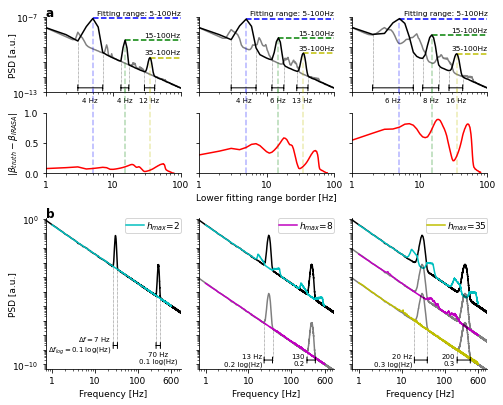

In [11]:
fig, ax = plt.subplots(3, 3, figsize=[fig_width, 5.5],
                       constrained_layout=True,
                       gridspec_kw=dict(height_ratios=[5, 4, 10]))

ax_a11 = ax[0, 0]
ax_a12 = ax[1, 0]
ax_a21 = ax[0, 1]
ax_a22 = ax[1, 1]
ax_a31 = ax[0, 2]
ax_a32 = ax[1, 2]

ax_b1 = ax[2, 0]
ax_b2 = ax[2, 1]
ax_b3 = ax[2, 2]

# a)
# a11
ax = ax_a11

# Plot sim
ax.loglog(freq_a, full_psd_a, c_sim)
ax.loglog(freq0, psd_aperiodic_a, c_ap, zorder=0)
colors123 = [c_range1, c_range2, c_range3]
draw_fitrange(ax_a11, ax_a12, full_psd_a, freqs123, colors123)

annotate_range(ax, **fit_range_a11)
annotate_range(ax, **fit_range_a12)
annotate_range(ax, **fit_range_a13)

# Set axes
ax.text(s="a", **panel_labels, transform=ax.transAxes)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=10)
ax.yaxis.set_minor_locator(y_minor)
ax.set_yticklabels([], minor=True)
ax.set(**axes_a1)
ax.set_ylabel(ylabel_a1, labelpad=-5)

# a12
ax = ax_a12
ax.semilogx(*error_plot_a)

# Set axes
ax.set(**axes_a2)

# a21
ax = ax_a21

# Plot sim
ax.loglog(freq_a, full_psd_b, c_sim)
ax.loglog(freq0, psd_aperiodic_b, c_ap, zorder=0)
draw_fitrange(ax_a21, ax_a22, full_psd_b, freqs123, colors123)

annotate_range(ax, **fit_range_a21)
annotate_range(ax, **fit_range_a22)
annotate_range(ax, **fit_range_a23)

# Set axes
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=10)
ax.yaxis.set_minor_locator(y_minor)
ax.set_yticklabels([], minor=True)
ax.set(**axes_a21)

# a22
ax = ax_a22
ax.semilogx(*error_plot_b)
ax.set_xlabel(xlabel_a2)

# Set axes
ax.set(**axes_a22)

# a31
ax = ax_a31
ax.loglog(freq_a, full_psd_c, c_sim)
ax.loglog(freq0, psd_aperiodic_c, c_ap, zorder=0)
draw_fitrange(ax_a31, ax_a32, full_psd_c, freqs123, colors123)

annotate_range(ax, **fit_range_a31)
annotate_range(ax, **fit_range_a32)
annotate_range(ax, **fit_range_a33)

# Set axes
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=10)
ax.yaxis.set_minor_locator(y_minor)
ax.set_yticklabels([], minor=True)
ax.set(**axes_a21)

# a32
ax = ax_a32
ax.semilogx(*error_plot_c)

# Set axes
ax.set(**axes_a22)


# b)
# b1
ax = ax_b1
ax.loglog(freqs_s, full_psd_s, c_sim)
ax.loglog(freqs_sim_s, ap_sim_s_h1, c_h1,
          label=r"$h_{max}$="f"{h_max_s}")

# annotate freq bandwidth
annotate_range(ax, **anno_small1)
annotate_range(ax, **anno_small2)

# Set axes
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=20)
ax.yaxis.set_minor_locator(y_minor)
ax.set_yticklabels([], minor=True)
ax.set_ylabel(ylabel_a1, labelpad=-5)

ax.set(**axes_b1)
ax.text(s="b", **panel_labels, transform=ax.transAxes)
ax.legend(**leg)

# b2
ax = ax_b2
ax.loglog(freqs_m, full_psd_m, c_sim)
ax.loglog(freqs_sim_m, ap_sim_m_h1, c_h1)

ax.loglog(freqs_m, peak_psd_m_low, c_sim, alpha=.5)
ax.loglog(freqs_sim_m, ap_sim_m_h2, c_h3,
          label=r"$h_{max}$="f"{h_max_m}")

# annotate freq bandwidth
annotate_range(ax, **anno_med1)
annotate_range(ax, **anno_med2)

# Set axes
ax.set(**axes_b2)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=20)
ax.yaxis.set_minor_locator(y_minor)
ax.set_yticklabels([], minor=True)
ax.legend(**leg)

# b3
ax = ax_b3
ax.loglog(freqs_l, full_psd_l, c_sim)
ax.loglog(freqs_sim_l, ap_sim_l_h1, c_h1)

ax.loglog(freqs_l, peak_psd_l_low, c_sim, alpha=.5)
ax.loglog(freqs_sim_l, ap_sim_l_h2, c_h3)

ax.loglog(freqs_l, peak_psd_l_lower, c_sim, alpha=.5)
ax.loglog(freqs_sim_l, ap_sim_l_h3, c_h2,
          label=r"$h_{max}$="f"{h_max_l}")

# annotate freq bandwidth
annotate_range(ax, **anno_large1)
annotate_range(ax, **anno_large2)

# Set axes
ax.set(**axes_b2)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=20)
ax.yaxis.set_minor_locator(y_minor)
ax.set_yticklabels([], minor=True)
ax.legend(**leg)

plt.savefig(fig_path + "Fig6.pdf", bbox_inches="tight")
plt.savefig(fig_path + "Fig6.png", dpi=1000, bbox_inches="tight")
plt.show()

# Supplementary Material: Apply to real data of dataset 2 with different peak widths

In [12]:
# %% Load data
path = "../data/Fig6/"
fname_MEG = "Subj016_ON_1_raw.fif"
fname_LFP = "Subj016_OFF_001_STN_r+s_raw.fif"

sub_MEG = mne.io.read_raw_fif(path + fname_MEG, preload=True)
sub_LFP = mne.io.read_raw_fif(path + fname_LFP, preload=True)

grad_s = "MEG0913"
mag_m = "MEG0113"
LFP_l = "R2-R3"

channels = [grad_s, mag_m]

sub_MEG.pick_channels(channels, ordered=True)
sub_LFP.pick_channels([LFP_l])

# Convert to numpy
MEG_raw = sub_MEG.get_data()
LFP_raw = sub_LFP.get_data()[0]
LFP_raw *= 1e6  # convert V to uV

freq, spec_MEG = sig.welch(MEG_raw, **welch_params)
freq, spec_LFP = sig.welch(LFP_raw, **welch_params)

filt = (freq <= 1200)
freq_filt = freq[filt]
spec_GRAD = spec_MEG[0, filt]
spec_MAG = spec_MEG[1, filt]

plot_s = (freq_filt, spec_GRAD, c_real)
plot_m = (freq_filt, spec_MAG, c_real)
plot_l = (freq, spec_LFP, c_real)

plot_m_low = (freq_filt, spec_MAG/10, c_real)
plot_l_low = (freq, spec_LFP/10, c_real)

Opening raw data file ../data/Fig6/Subj016_ON_1_raw.fif...
Isotrak not found
    Range : 0 ... 1447499 =      0.000 ...   603.125 secs
Ready.
Reading 0 ... 1447499  =      0.000 ...   603.125 secs...
Opening raw data file ../data/Fig6/Subj016_OFF_001_STN_r+s_raw.fif...
    Range : 0 ... 1445999 =      0.000 ...   602.751 secs
Ready.
Reading 0 ... 1445999  =      0.000 ...   602.751 secs...


#### Apply fooof to determine peak width

In [13]:
real_s = FOOOF(max_n_peaks=2, verbose=False)
real_m = FOOOF(max_n_peaks=1, verbose=False, peak_width_limits=(0.5, 150))
real_l = FOOOF(max_n_peaks=1, verbose=False, peak_width_limits=(.5, 150))

real_s.fit(freq, spec_MEG[0], (3, 20))
real_m.fit(freq, spec_MEG[1], (1, 100))
real_l.fit(freq, spec_LFP, (10, 150))

freq_real_s, pow_real_s, bw_real_s = real_s.peak_params_[0]
freq_real_m, pow_real_m, bw_real_m = real_m.peak_params_[0]
freq_real_l, pow_real_l, bw_real_l = real_l.peak_params_[0]

#### Apply IRASA (may take around 4 minutes)

In [14]:
# maximum resampling factors
h_max1 = 2
h_max2 = 25

# doesn't matter that shorter band makes more sence, this is topic of fig4
band = (1, 100)
highpass = .3  # Hz
lowpass = 600  # Hz
band_h1 = (highpass * h_max1, lowpass / h_max1)
band_h2 = (highpass * h_max2, lowpass / h_max2)

N_h = 16  # number of resampling factors

# params
irasa_params1 = dict(sf=sample_rate, band=band_h1,
                     hset=np.linspace(1.1, h_max1, N_h))
irasa_params2 = dict(sf=sample_rate, band=band_h2,
                     hset=np.linspace(1.1, h_max2, N_h))

# Apply IRASA
IRASA_s_h1 = irasa(MEG_raw[0], **irasa_params1)
IRASA_m_h1 = irasa(MEG_raw[1], **irasa_params1)
IRASA_l_h1 = irasa(LFP_raw, **irasa_params1)
IRASA_m_h2 = irasa(MEG_raw[1], **irasa_params2)
IRASA_l_h2 = irasa(LFP_raw, **irasa_params2)

# Unpack results
freq_I_h1, aperiodic_s_h1, periodic_s_h1, _ = IRASA_s_h1
_, aperiodic_m_h1, periodic_m_h1, params_m_h1 = IRASA_m_h1
_, aperiodic_l_h1, periodic_l_h1, params_l_h1 = IRASA_l_h1
freq_I_h2, aperiodic_m_h2, periodic_m_h2, params_m_h2 = IRASA_m_h2
freq_I_h2, aperiodic_l_h2, periodic_l_h2, _ = IRASA_l_h2

# pack lines for plotting
plot_aperiodic_s_h1 = (freq_I_h1, aperiodic_s_h1[0], c_ap_real1)
plot_aperiodic_m_h1 = (freq_I_h1, aperiodic_m_h1[0], c_ap_real1)
plot_aperiodic_l_h1 = (freq_I_h1, aperiodic_l_h1[0], c_ap_real1)
plot_aperoidic_m_h2 = (freq_I_h2, aperiodic_m_h2[0]/10, c_ap_real2)
plot_aperiodic_l_h2 = (freq_I_h2, aperiodic_l_h2[0]/10, c_ap_real2)

# Show what happens for larger freq ranges
irasa_params2["band"] = band_h1  # params

# Apply IRASA
IRASA_m_h1_long = irasa(MEG_raw[1], **irasa_params1)
IRASA_l_h1_long = irasa(LFP_raw, **irasa_params1)
IRASA_m_h2_long = irasa(MEG_raw[1], **irasa_params2)
IRASA_l_h2_long = irasa(LFP_raw, **irasa_params2)

# Unpack results
freq_I_long, aperiodic_m_h1_long, _, _ = IRASA_m_h1_long
_, aperiodic_l_h1_long, _, _ = IRASA_l_h1_long
_, aperiodic_m_h2_long, _, _ = IRASA_m_h2_long
_, ap_l_h2_long, _, _ = IRASA_l_h2_long

# pack lines for plotting
plot_ap_m_h1_long = (freq_I_long, aperiodic_m_h1_long[0], c_ap_real1)
plot_ap_l_h1_long = (freq_I_long, aperiodic_l_h1_long[0], c_ap_real1)
plot_ap_m_h2_long = (freq_I_long, aperiodic_m_h2_long[0]/10, c_ap_real2)
plot_ap_l_h2_long = (freq_I_long, ap_l_h2_long[0]/10, c_ap_real2)

#### Plot settings

In [15]:
alpha_long = .3
ylabel_a = r"$\left(T/m\right)^2$/Hz"
ylabel_b = r"$T^2/Hz$"
ylabel_c = r"$\mu V^2/Hz$"
xlabel = "Frequency [Hz]"
xticks_a = [1, 10, 100, 600]
xticks_bc = [1, 10, 100, 1000]

# Figure 6

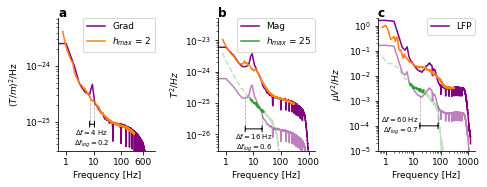

In [16]:
fig, axes = plt.subplots(1, 3, figsize=[fig_width, 2.7])

# a)
ax = axes[0]
ax.loglog(*plot_s, label="Grad")
ax.loglog(*plot_aperiodic_s_h1, label=r"$h_{max}$ = "f"{h_max1}")
ax.set_ylabel(ylabel_a)
ax.set_xlabel(xlabel)
ymin, ymax = ax.get_ylim()
ax.set_ylim((3e-26, ymax))
ax.text(s="a", **panel_labels, transform=ax.transAxes)

# annotate freq bandwidth
xmin = freq_real_s - bw_real_s
xmax = freq_real_s + bw_real_s
ylow = plot_s[1][np.argmin(np.abs(plot_s[0] - xmin))]
yhigh = plot_s[1][np.argmin(np.abs(plot_s[0] - xmax))]
height = 9e-26
annotate_range(ax, xmin=xmin, xmax=xmax, ylow=ylow, yhigh=yhigh,
               height=height, annotate_pos=.55)
ax.set_xticks(xticks_a)
ax.set_xticklabels(xticks_a)
ax.legend(loc=1, borderaxespad=0)

# b)
ax = axes[1]
ax.loglog(*plot_m, label="Mag")
ax.loglog(*plot_aperiodic_m_h1)
ax.loglog(*plot_ap_m_h1_long, ls="--", alpha=alpha_long)

ax.loglog(*plot_m_low, alpha=.5)
ax.loglog(*plot_aperoidic_m_h2, label=r"$h_{max}$ = "f"{h_max2}")
ax.loglog(*plot_ap_m_h2_long, ls="--", alpha=alpha_long)

ax.set_ylabel(ylabel_b)
ax.set_xlabel(xlabel)
ax.text(s="b", **panel_labels, transform=ax.transAxes)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=10)
ax.yaxis.set_minor_locator(y_minor)
ax.set_yticklabels([], minor=True)
ylim = (3e-27, 5e-23)
ax.set_ylim(ylim)
ax.legend(loc=1, borderaxespad=0)

# annotate freq bandwidth
xmin = freq_real_m - bw_real_m + 2
xmax = freq_real_m + bw_real_m + 2
ylow = plot_m_low[1][np.argmin(np.abs(plot_m_low[0] - xmin))]
yhigh = plot_m_low[1][np.argmin(np.abs(plot_m_low[0] - xmax))]
height = 5 * ylim[0]
annotate_range(ax, xmin=xmin, xmax=xmax, ylow=ylow, yhigh=yhigh,
               height=height, annotate_pos=.35)
ax.set_xticks(xticks_bc)
ax.set_xticklabels(xticks_bc)

# c)
ax = axes[2]
ax.loglog(*plot_l, label="LFP")
ax.loglog(*plot_aperiodic_l_h1)
ax.loglog(*plot_ap_l_h1_long, ls="--", alpha=alpha_long)

ax.loglog(*plot_l_low, alpha=.5)
ax.loglog(*plot_aperiodic_l_h2)
ax.loglog(*plot_ap_l_h2_long, ls="--", alpha=alpha_long)

ax.set_ylabel(ylabel_c)
ax.set_xlabel(xlabel)
ax.legend(loc=1, borderaxespad=0)
ylim = (1e-5, 2)
ax.set_ylim(ylim)
ax.text(s="c", **panel_labels, transform=ax.transAxes)
x_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=10)
ax.xaxis.set_minor_locator(x_minor)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=10)
ax.yaxis.set_minor_locator(y_minor)
ax.set_yticklabels([], minor=True)

# annotate freq bandwidth
xmin = freq_real_l - bw_real_l
xmax = freq_real_l + bw_real_l
ylow = plot_l_low[1][np.argmin(np.abs(plot_l_low[0] - xmin))]
yhigh = plot_l_low[1][np.argmin(np.abs(plot_l_low[0] - xmax))]
height = 10 * ylim[0]
annotate_range(ax, xmin=xmin, xmax=xmax, ylow=ylow, yhigh=yhigh,
               height=height, annotate_pos="left")
ax.set_xticks(xticks_bc)
ax.set_xticklabels(xticks_bc)

plt.tight_layout()
plt.savefig(fig_path + "Fig6_SuppMat.pdf", bbox_inches="tight")
plt.show()